# Analyzing environmental impacts of urban expansion in Phoeniz, Arizona (2017-2020)
Author: Kat Le


## About


## Highlights


## Data
2020 Tiger/Line shapefiles: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr

import pystac_client
import stackstac
import rich.table
from geogif import gif

from pystac_client import Client # To access STAC catalogues

import planetary_computer # To sign items from MPC STAC Catalogue

from IPython.display import Image

### Access
We use the `Client` function from the `pystac_client` package to access the catalog:

In [2]:
# Access MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]
search = catalog.search(collections=["io-biodiversity"], bbox=bbox_of_interest)

items = list(search.items())
for item in items:
    print(item)

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


In [4]:
asset_table = rich.table.Table("Asset Key", "Asset Title")
for key, value in items[-1].assets.items():
    asset_table.add_row(key, value.title)
asset_table

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Asset Title                     ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data             │ Biodiversity Intactness         │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

In [5]:
property_table = rich.table.Table("Property Name", "Property Value")
for key, value in sorted(items[-1].properties.items()):
    property_table.add_row(key, str(value))
property_table

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Property Name  ┃ Property Value                                                                                 ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ datetime       │ None                                                                                           │
│ end_datetime   │ 2017-12-31T23:59:59Z                                                                           │
│ proj:epsg      │ 4326                                                                                           │
│ proj:shape     │ [7992, 7992]                                                                                   │
│ proj:transform │ [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215,                 │
│                │ 34.74464974521749, 0.0, 0.0, 1.0]                                                              │
│ start_datetime │ 2017-01-01T00:00:00Z                                                                           │
└────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

In [6]:
stack = (
    stackstac.stack(items, bounds_latlon=bbox_of_interest, assets=["data"])
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items])
        .tz_convert(None)
        .to_numpy()
    )
    .sortby("time")
)
stack.name = "Biodiversity Intactness"
stack

<xarray.DataArray 'Biodiversity Intactness' (time: 4, band: 1, y: 991, x: 1830)> Size: 58MB
dask.array<getitem, shape=(4, 1, 991, 1830), dtype=float64, chunksize=(1, 1, 991, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
    id              (time) <U50 800B 'bii_2017_34.74464974521749_-115.3859782...
  * band            (band) <U4 16B 'data'
  * x               (x) float64 15kB -112.8 -112.8 -112.8 ... -111.2 -111.2
  * y               (y) float64 8kB 33.86 33.86 33.86 ... 32.98 32.98 32.97
    end_datetime    (time) <U20 320B '2017-12-31T23:59:59Z' ... '2020-12-31T2...
    proj:transform  object 8B {0.0, 1.0, 34.74464974521749, 0.000898315284119...
    ...              ...
    raster:bands    object 8B {'sampling': 'area', 'data_type': 'float32', 's...
    version         <U2 8B 'v1'
    description     <U54 216B 'Terrestrial biodiversity intactness at 100m re...
    title           <U23 92B 'Biodiversity Intactness'
    epsg            int64 8B 4326
  * time            (time) datetime64[ns] 32B 2017-01-01 ... 2020-01-01
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-112.82750137012779, 32.973560...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-112.83|\n| 0.00,-0.00, 33.86|\n| 0.00, 0.00, 1...
    resolution:  0.0008983152841195215

In [7]:
data_array = stack.squeeze().compute()

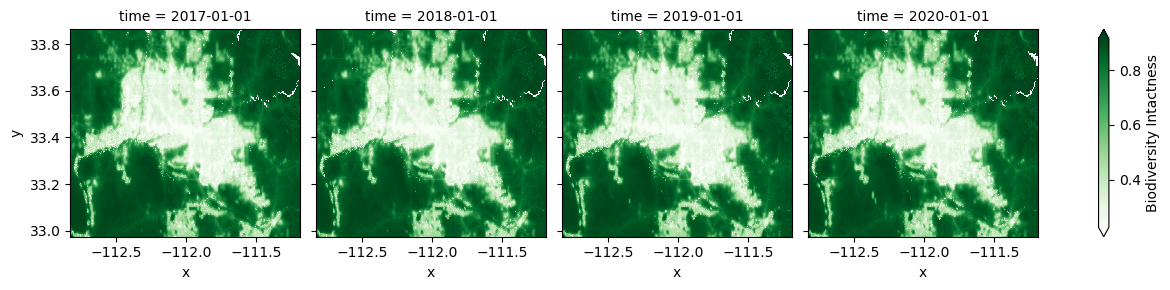

In [8]:
grid = data_array.plot(col="time", cmap="Greens", robust=True)
grid;

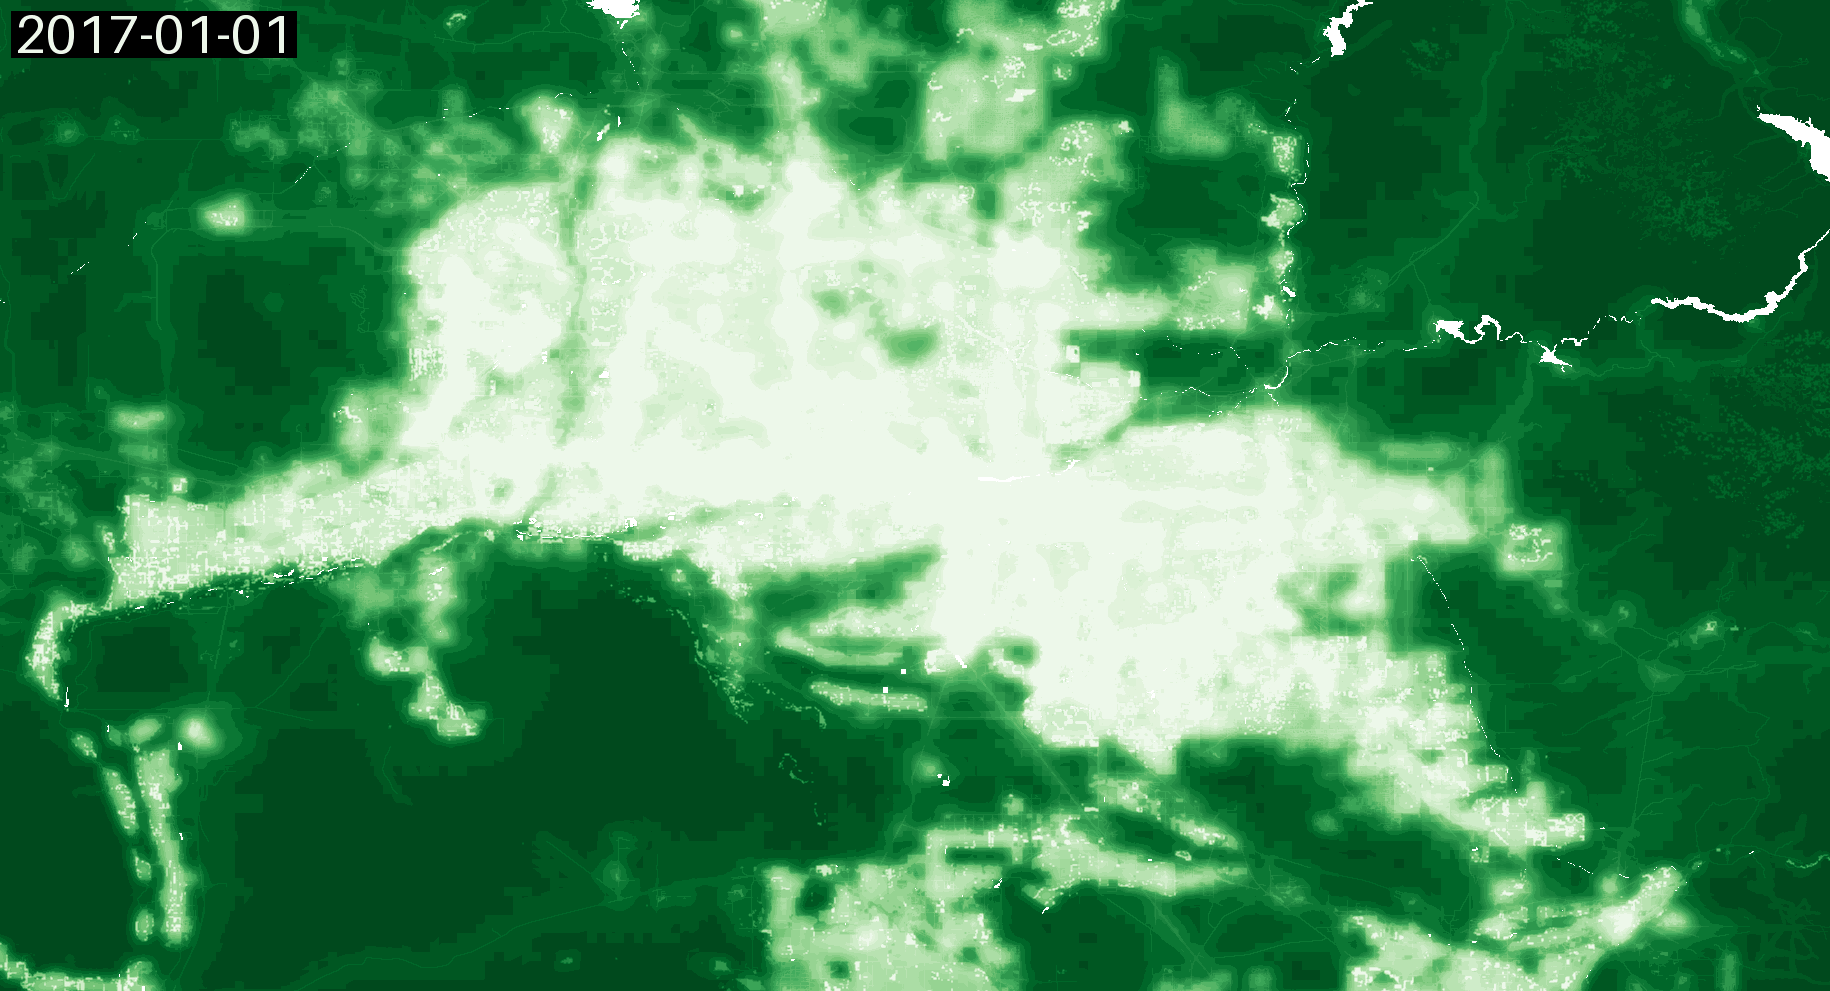

In [9]:
gif(data_array, fps=1, cmap="Greens", robust=True)